In [197]:
import dask.dataframe as dd
import time
from matplotlib import pyplot as plt
import numpy as np
from collections import Counter
import pandas as pd
import seaborn as sns
from sklearn import metrics
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split, cross_val_score 
from sklearn.linear_model import LinearRegression 
from sklearn import tree
from sklearn.ensemble import RandomForestRegressor

In [198]:
start_time = time.time()
train_df = dd.read_csv('train.csv').head(n=10000000, npartitions = 20)
train_df =  train_df.sample(frac = 0.5,replace=True)
print("Time taken to read = %s seconds" % (time.time() - start_time))

Time taken to read = 102.544105052948 seconds


In [199]:
train_df.head()

,key,fare_amount,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count
274958,2014-10-05 20:44:00.000000114,7.0,2014-10-05 20:44:00 UTC,-73.985052,40.741987,-73.987418,40.728877,2
253420,2013-12-13 10:03:56.0000004,11.0,2013-12-13 10:03:56 UTC,-73.981250,40.737612,-73.999713,40.721777,1
543710,2009-11-25 01:55:43.0000001,14.5,2009-11-25 01:55:43 UTC,-73.990479,40.755819,-73.938523,40.812639,1
249754,2011-08-31 16:03:00.000000122,6.5,2011-08-31 16:03:00 UTC,-73.994835,40.755167,-74.007958,40.739370,1
266425,2009-02-28 12:44:00.00000052,8.5,2009-02-28 12:44:00 UTC,-73.961638,40.796080,-73.954754,40.777642,1


###  **DATA CLEANING**
 - Passenger count cannot be negative or zero. Maximum number of passengers allowed is 7.
 - Minimum Fare amount for NYC cabs is 2.5 dollars.
 - Pickup lat/long and Dropoff lat/long cannot be the same. Check for valid lat/long (which cannot be outside the        range for lat --> -90 to 90 & longitude --> -180 to 180)
 - Convert the data type of 'pickup_datetime' to datetime

In [200]:
train_df.shape[0]

5000000

In [201]:
print('\033[1m'+"Passenger count <= 0: \n",train_df['passenger_count'][(train_df.passenger_count<=0)].count())

Passenger count <= 0: 
 17705


In [202]:
print('\033[1m'+"Passenger count > 7: \n",train_df['passenger_count'][(train_df['passenger_count'] > 7)].count())

Passenger count > 7: 
 9


In [203]:
#train_df[train_df['passenger_count']==0].head
#train_df[(train_df['passenger_count'] >7)].head

In [204]:
train_df = train_df[(train_df['passenger_count'] <= 7)]

In [205]:
train_df.shape[0]

4999991

In [206]:
print('\033[1m'+"Fare amount < 2.5: \n",train_df['fare_amount'][(train_df.fare_amount<2.5)].count())

Fare amount < 2.5: 
 419


In [207]:
print('\033[1m'+"Fare amount > 500: \n",train_df['fare_amount'][(train_df.fare_amount>500)].count())

Fare amount > 500: 
 3


In [208]:
train_df = train_df[(train_df.fare_amount>=2.5) & (train_df.fare_amount<=500)]

In [209]:
train_df.shape

(4999569, 8)

In [189]:
# latitude and longitude are bounded by 90 and -90. We shouldnt have any coordiantes out of that range
# train_df = train_df[(train_df['pickup_latitude']<=90) & (train_df['pickup_latitude']>=-90)]
# train_df = train_df[(train_df['pickup_longitude']<=180) & (train_df['pickup_longitude']>=-180)]
# train_df = train_df[(train_df['dropoff_latitude']<=90) & (train_df['dropoff_latitude']>=-90)]
# train_df = train_df[(train_df['dropoff_longitude']<=180) & (train_df['dropoff_longitude']>=-180)]

In [190]:
# train_df.shape[0]

Text(0, 0.5, 'Frequency')

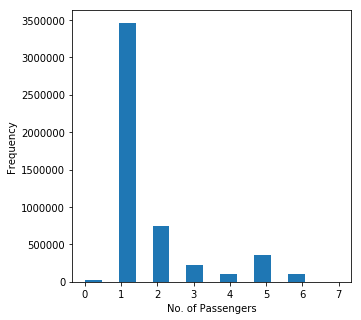

In [210]:
plt.figure(figsize=(5,5))
plt.hist(train_df['passenger_count'], bins=15)
plt.xlabel('No. of Passengers')
plt.ylabel('Frequency')

In [ ]:
#fig, ax = plt.subplots()
#hist = ax.hist2d(train_df['passenger_count'], train_df['fare_amount'])
#plt.bar(train_df['passenger_count'], train_df['fare_amount'])
#ax.set_xticks(train_df['passenger_count'])
#plt.show(block=False)
index = np.arange(len(train_df['passenger_count']))
plt.bar(index, train_df['fare_amount'])
plt.xlabel('Genre', fontsize=5)
plt.ylabel('No of Movies', fontsize=5)
plt.xticks(index, train_df['passenger_count'], fontsize=5, rotation=30)
plt.title('Market Share for Each Genre 1995-2017')
plt.show()

Text(0, 0.5, 'Fare')

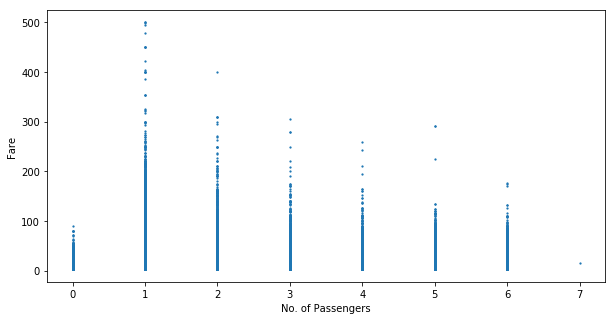

In [211]:
plt.figure(figsize=(10,5))
plt.scatter(x=train_df['passenger_count'], y=train_df['fare_amount'], s=1.5)
plt.xlabel('No. of Passengers')
plt.ylabel('Fare')

In [212]:
train_df.shape

(4999569, 8)

In [213]:
train_df.dtypes

key                   object
fare_amount          float64
pickup_datetime       object
pickup_longitude     float64
pickup_latitude      float64
dropoff_longitude    float64
dropoff_latitude     float64
passenger_count        int64
dtype: object

In [214]:
train_df['pickup_datetime']=dd.to_datetime(train_df['pickup_datetime'], infer_datetime_format=True)

In [215]:
train_df.dtypes

key                          object
fare_amount                 float64
pickup_datetime      datetime64[ns]
pickup_longitude            float64
pickup_latitude             float64
dropoff_longitude           float64
dropoff_latitude            float64
passenger_count               int64
dtype: object

### **FEATURE ENGINEERING**
 - Split the pickup_datetime column into day, month, year, day of week, hour, minute, second to verify if the fare 
   amount prediction depends on these parameters.
 - Calculate the haversine distance in miles using the pickup/dropoff latitude/longitude values  

In [216]:
#Time of day
train_df['Hour'] = train_df['pickup_datetime'].dt.hour
train_df['Minute'] = train_df['pickup_datetime'].dt.minute
train_df['Second'] = train_df['pickup_datetime'].dt.second

#Days of week 0-Monday 1-Tuesday 2-Wednesday 3-Thursday 4-Friday 5-Saturday 6-Sunday
train_df['day_of_week'] = train_df['pickup_datetime'].dt.weekday

#Date format mm dd year
train_df['Month'] = train_df['pickup_datetime'].dt.month
train_df['Date'] = train_df['pickup_datetime'].dt.day
train_df['Year'] = train_df['pickup_datetime'].dt.year

In [217]:
train_df['Hour'].describe()

count    4.999569e+06
mean     1.350974e+01
std      6.515808e+00
min      0.000000e+00
25%      9.000000e+00
50%      1.400000e+01
75%      1.900000e+01
max      2.300000e+01
Name: Hour, dtype: float64

In [218]:
train_df['day_of_week'].describe()

count    4.999569e+06
mean     3.041659e+00
std      1.948573e+00
min      0.000000e+00
25%      1.000000e+00
50%      3.000000e+00
75%      5.000000e+00
max      6.000000e+00
Name: day_of_week, dtype: float64

In [219]:
def over_night (row):
    if (row['Hour'] >= 20) or (row['Hour'] <= 6):
        return 1
    else:
        return 0


def rush_hour (row):
    if ((row['Hour'] >=16) and (row['Hour'] <= 20)) and (row['day_of_week'] <= 4):
        return 1
    else:
        return 0
    
train_df['rush_hour'] = train_df.apply(lambda x: rush_hour(x), axis=1)
train_df['over_night'] = train_df.apply(lambda x: over_night(x), axis=1)   

In [220]:
#print(data.describe())
def distance(data):
    R = 3956        # Radius of earth in miles
    
    pickup_data = data[['pickup_longitude','pickup_latitude']]
    dropoff_data = data[['dropoff_longitude','dropoff_latitude']]
    
    phi1 = np.radians(pickup_data['pickup_latitude'])
    phi2 = np.radians(dropoff_data['dropoff_latitude'])
    
    delta_phi = np.radians(dropoff_data['dropoff_latitude'] - pickup_data['pickup_latitude'])
    delta_lambda = np.radians(dropoff_data['dropoff_longitude'] - pickup_data['pickup_longitude'])
    
    #a = sin²((φB - φA)/2) + cos φA . cos φB . sin²((λB - λA)/2)
    a = np.sin((delta_phi)/2)**2 + np.cos(phi1)*np.cos(phi2)*np.sin(delta_lambda/2)**2
    
    #c = 2 * atan2( √a, √(1−a) )
    c = 2 * np.arctan2(np.sqrt(a),np.sqrt(1-a))
    d = R * c
    
    return d

# add new column to dataframe with distance in miles
train_df['distance_in_miles'] = distance(train_df)
# train_df['distance_in_miles'] = distance(train_df.pickup_latitude, train_df.pickup_longitude,
#                                       train_df.dropoff_latitude, train_df.dropoff_longitude)

In [221]:
# Given a dataframe, add two new features 'abs_diff_longitude' and
# 'abs_diff_latitude' reprensenting the "Manhattan vector" from
# the pickup location to the dropoff location.
def add_travel_vector_features(df):
    df['abs_diff_longitude'] = (df.dropoff_longitude - df.pickup_longitude).abs()
    df['abs_diff_latitude'] = (df.dropoff_latitude - df.pickup_latitude).abs()

add_travel_vector_features(train_df)

In [222]:
print('Old size: %d' % len(train_df))
train_df = train_df.dropna(how = 'any', axis = 'rows')
print('New size: %d' % len(train_df))

Old size: 4999569
New size: 4999539


In [224]:
def distanceNyc(lat1, lon1, lat2, lon2):
    p = 0.017453292519943295 # Pi/180
    a = 0.5 - np.cos((lat2 - lat1) * p)/2 + np.cos(lat1 * p) * np.cos(lat2 * p) * (1 - np.cos((lon2 - lon1) * p)) / 2
    return 0.6213712 * 12742 * np.arcsin(np.sqrt(a)) # 2*R*asin...

print('Old size: %d' % len(train_df))
train_df = train_df[(train_df.abs_diff_longitude < 3.0) & (train_df.abs_diff_latitude < 3.0)]
train_df = train_df[(train_df.pickup_longitude >= -74.3) & (train_df.pickup_longitude <= -72.9)]  # nyc coordinates
train_df = train_df[(train_df.dropoff_longitude >= -74.3) & (train_df.dropoff_longitude <= -72.9)]
train_df = train_df[(train_df.pickup_latitude >= 40.5) & (train_df.pickup_latitude <= 41.8)]
train_df = train_df[(train_df.dropoff_latitude >= 40.5) & (train_df.dropoff_latitude <= 41.8)]
train_df = train_df[(train_df.distance_in_miles<=100.0) & (train_df.distance_in_miles>0.05)]
nyc = (-74.0063889, 40.7141667)
train_df['distance_to_center'] = distanceNyc(nyc[1], nyc[0],train_df.dropoff_latitude, train_df.dropoff_longitude)
train_df = train_df[train_df.distance_to_center<15.0]
print('New size: %d' % len(train_df))

Old size: 4816271
New size: 4811672


In [225]:
(train_df.head())

,key,fare_amount,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,Hour,Minute,...,day_of_week,Month,Date,Year,rush_hour,over_night,distance_in_miles,abs_diff_longitude,abs_diff_latitude,distance_to_center
274958,2014-10-05 20:44:00.000000114,7.0,2011-11-28 14:07:20,-73.985052,40.741987,-73.987418,40.728877,2,14,7,...,0,11,28,2011,0,0,0.913607,0.002366,0.013110,1.421234
253420,2013-12-13 10:03:56.0000004,11.0,2011-11-28 14:07:20,-73.981250,40.737612,-73.999713,40.721777,1,14,7,...,0,11,28,2011,0,0,1.458964,0.018463,0.015835,0.631435
543710,2009-11-25 01:55:43.0000001,14.5,2015-04-24 23:05:19,-73.990479,40.755819,-73.938523,40.812639,1,23,5,...,4,4,24,2015,0,1,4.771685,0.051956,0.056820,7.674961
249754,2011-08-31 16:03:00.000000122,6.5,2013-03-22 23:54:55,-73.994835,40.755167,-74.007958,40.739370,1,23,54,...,4,3,22,2013,0,1,1.288738,0.013123,0.015797,1.743317
266425,2009-02-28 12:44:00.00000052,8.5,2009-11-03 23:02:06,-73.961638,40.796080,-73.954754,40.777642,1,23,2,...,1,11,3,2009,0,1,1.322945,0.006884,0.018438,5.151706


In [226]:
train_df.dtypes

key                           object
fare_amount                  float64
pickup_datetime       datetime64[ns]
pickup_longitude             float64
pickup_latitude              float64
dropoff_longitude            float64
dropoff_latitude             float64
passenger_count                int64
Hour                           int64
Minute                         int64
Second                         int64
day_of_week                    int64
Month                          int64
Date                           int64
Year                           int64
rush_hour                      int64
over_night                     int64
distance_in_miles            float64
abs_diff_longitude           float64
abs_diff_latitude            float64
distance_to_center           float64
dtype: object

In [227]:
# rangeA = 1.5
# rangeN = 20.0
# rangeS = 48.7
# rangeR = 14.1
# rangeD = 28.7
# rangeO = 29
# rangeP = 15.7
# rangeW = 20.0
# jfk = (-73.7822222222, 40.6441666667) #JFK Airport
# ewr = (-74.175, 40.69) # Newark Liberty International Airport
# lgr = (-73.87, 40.77) # LaGuardia Airport

#  # county
# Nassau = (-73.5594, 40.6546)
# Suffolk = (-72.6151, 40.9849)
# Westchester = (-73.7949, 41.1220)
# Rockland = (-73.9830, 41.1489)
# Dutchess = (-73.7478, 41.7784)
# Orange = (-74.3118, 41.3912)
# Putnam = (-73.7949, 41.4351) 

# data_air=train_df

# def add_checkpoint(point, point_name,rangeA):
#     data_air[point_name] = (distance(train_df.pickup_latitude, train_df.pickup_longitude, point[1], point[0]) <= rangeA) | ((distance(train_df.dropoff_latitude, train_df.dropoff_longitude, point[1], point[0]) <= rangeA))
#     data_air[point_name].replace(False, 0, inplace=True)
#     data_air[point_name] = data_air[point_name].astype(int)

# add_checkpoint(jfk, 'jfk',rangeA)
# add_checkpoint(ewr, 'ewr',rangeA)
# add_checkpoint(lgr, 'lgr',rangeA)
# add_checkpoint(Nassau, 'Nassau',rangeN)
# add_checkpoint(Suffolk, 'Suffolk',rangeS)
# add_checkpoint(Westchester, 'Westchester',rangeW)
# add_checkpoint(Rockland, 'Rockland',rangeR )
# add_checkpoint(Dutchess, 'Dutchess',rangeD)
# add_checkpoint(Orange, 'Orange',rangeO)
# add_checkpoint(Putnam, 'Putnam',rangeP)

# data_air = train_df[(data_air.jfk | data_air.ewr | data_air.lgr | data_air.Nassau | data_air.Suffolk | data_air.Westchester | data_air.Rockland | data_air.Dutchess | data_air.Orange | data_air.Putnam)==1]
# data_air['airport'] = (data_air.jfk | data_air.ewr | data_air.lgr )==1
# data_air['airport'].replace(False, 0, inplace=True)
# data_air['airport'] = data_air['airport'].astype(int)
# data_air['county1'] = (data_air.jfk | data_air.ewr | data_air.lgr )==0
# data_air['county1'] = (data_air.Nassau | data_air.Westchester)==1
# data_air['county1'].replace(False, 0, inplace=True)
# data_air['county1'] = data_air['county1'].astype(int)
# data_air['county2'] = (data_air.jfk | data_air.ewr | data_air.lgr | data_air.Nassau | data_air.Westchester)==0
# data_air['county2'].replace(False, 0, inplace=True)
# data_air['county2'] = data_air['county2'].astype(int)
# train_df = train_df[(train_df.jfk | train_df.ewr | train_df.lgr | train_df.Nassau | train_df.Suffolk | train_df.Westchester | train_df.Rockland | train_df.Dutchess | train_df.Orange | train_df.Putnam)==0]
# data_air.describe()

In [228]:
train_df.to_csv('FinalData.csv')

In [36]:
#plt.figure(figsize=(10,5))
#plt.scatter(x=train_df['Date'], y=train_df['fare_amount'], s=1.5)
#plt.xlabel('Date')
#plt.ylabel('Fare')

In [264]:
columns = ['fare_amount', 'pickup_datetime',
       'pickup_longitude', 'pickup_latitude', 'dropoff_longitude',
       'dropoff_latitude', 'passenger_count', 'Hour', 'Minute', 'Second',
       'day_of_week', 'Month', 'Date', 'Year', 'rush_hour', 'over_night',
       'distance_in_miles', 'abs_diff_longitude', 'abs_diff_latitude',
       'distance_to_center']
learning_data = pd.read_csv('FinalData.csv',usecols = columns).sample(n=1000000)

In [265]:
learning_data.shape

(1000000, 20)

In [266]:
learning_data.columns

Index(['fare_amount', 'pickup_datetime', 'pickup_longitude', 'pickup_latitude',
       'dropoff_longitude', 'dropoff_latitude', 'passenger_count', 'Hour',
       'Minute', 'Second', 'day_of_week', 'Month', 'Date', 'Year', 'rush_hour',
       'over_night', 'distance_in_miles', 'abs_diff_longitude',
       'abs_diff_latitude', 'distance_to_center'],
      dtype='object')

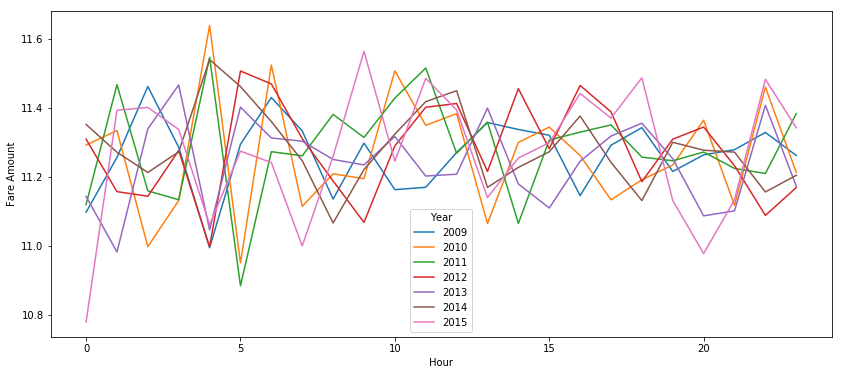

In [267]:
# display pivot table
learning_data.pivot_table('fare_amount', index='Hour', columns='Year').plot(figsize=(14,6))
plt.ylabel('Fare Amount');
# plt.axis([0, 23, 0, 20])

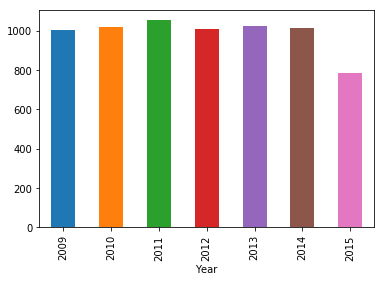

In [268]:
learning_data.groupby('Year')['fare_amount'].nunique().plot(kind='bar')
plt.show()

## MODEL SELECTION

In [269]:
y = learning_data['fare_amount']

In [271]:
X = learning_data.drop(['fare_amount','pickup_datetime','abs_diff_longitude','abs_diff_latitude'],axis = 1)

In [272]:
X.shape

(1000000, 16)

In [273]:
X.head()

,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,Hour,Minute,Second,day_of_week,Month,Date,Year,rush_hour,over_night,distance_in_miles,distance_to_center
1475281,-73.992096,40.750637,-74.003944,40.742287,1,5,53,45,1,3,13,2012,0,1,0.846488,1.947114
59045,-73.988550,40.764158,-73.997400,40.756633,1,16,27,46,2,6,12,2013,1,0,0.695821,2.971639
3270271,-73.976180,40.752115,-73.988322,40.738560,1,17,48,0,5,3,14,2009,0,0,1.131077,1.932757
437676,-73.985750,40.752247,-73.991278,40.739000,1,1,6,19,5,5,21,2011,0,1,0.959264,1.889459
4228478,-73.990710,40.734903,-74.000717,40.727378,1,23,59,0,4,2,6,2009,0,1,0.737618,0.959919


In [274]:
X_train, X_val, y_train, y_val = train_test_split(X, y, random_state=42, test_size = .3)

In [275]:
X_train.shape[0]

700000

In [276]:
y_train.shape[0]

700000

In [277]:
X_val.shape[0]

300000

In [278]:
y_val.shape[0]

300000

In [279]:
X_train.columns

Index(['pickup_longitude', 'pickup_latitude', 'dropoff_longitude',
       'dropoff_latitude', 'passenger_count', 'Hour', 'Minute', 'Second',
       'day_of_week', 'Month', 'Date', 'Year', 'rush_hour', 'over_night',
       'distance_in_miles', 'distance_to_center'],
      dtype='object')

### LINEAR REGRESSION

In [280]:
start_time = time.time()
lr = LinearRegression()
lr.fit(X_train, y_train)
#print("-------LINEAR REGRESSION------")
print("Training score: ",lr.score(X_train,y_train))
print("Validation score: ",lr.score(X_val,y_val))

y_pred = lr.predict(X_val)
print("Predicted output: ",y_pred)
rmse = np.sqrt(metrics.mean_squared_error(y_pred, y_val))
print("Mean Squared Error: ",rmse)
print("Time taken = %s seconds" % (time.time() - start_time))

Training score:  0.7588926359061628
Validation score:  0.7741518765715595
Predicted output:  [20.05005101 13.5310854   9.92638968 ...  8.77151295  7.50404446
 14.13337073]
Mean Squared Error:  4.3970899508849355
Time taken = 0.5932469367980957 seconds


### DECISION TREE REGRESSOR

In [281]:
start_time = time.time()
modelTreeReg = tree.DecisionTreeRegressor()
modelTreeReg.fit(X_train, y_train)

predictTreeReg = modelTreeReg.predict(X_val)
print("Predicted output: ",predictTreeReg)
tree_mse = mean_squared_error(y_val, predictTreeReg)
treeRMSE = np.sqrt(tree_mse)
print("Mean Squared error: ",treeRMSE)
print("Time taken = %s seconds" % (time.time() - start_time))

Predicted output:  [20.5 12.9  6.9 ...  2.5  8.5 13.5]
Mean Squared error:  4.908073590931578
Time taken = 20.27580690383911 seconds


In [282]:
start_time = time.time()
modelTreeReg1 = tree.DecisionTreeRegressor(max_depth=2)
modelTreeReg1.fit(X_train, y_train)

predictTreeReg1 = modelTreeReg1.predict(X_val)
print("Predicted output: ",predictTreeReg1)
tree_mse1 = mean_squared_error(y_val, predictTreeReg1)
treeRMSE1 = np.sqrt(tree_mse1)
print("Mean Squared error: ",treeRMSE1)
print("Time taken = %s seconds" % (time.time() - start_time))

Predicted output:  [28.59637381 14.09302124  7.25666644 ...  7.25666644  7.25666644
 14.09302124]
Mean Squared error:  4.598970537615432
Time taken = 1.6862819194793701 seconds


In [283]:
start_time = time.time()
modelTreeReg2 = tree.DecisionTreeRegressor(max_depth=5)
modelTreeReg2.fit(X_train, y_train)

predictTreeReg2 = modelTreeReg2.predict(X_val)
print("Predicted output: ",predictTreeReg2)
tree_mse2 = mean_squared_error(y_val, predictTreeReg2)
treeRMSE2 = np.sqrt(tree_mse2)
print("Mean Squared error: ",treeRMSE2)
print("Time taken = %s seconds" % (time.time() - start_time))

Predicted output:  [21.3721326  13.64932078  9.66683426 ...  8.5049981   7.82660289
 13.64932078]
Mean Squared error:  3.80599423357919
Time taken = 4.124997854232788 seconds


In [284]:
start_time = time.time()
modelTreeReg3 = tree.DecisionTreeRegressor(max_depth=7,random_state=0)
modelTreeReg3.fit(X_train, y_train)

predictTreeReg3 = modelTreeReg3.predict(X_val)
print("Predicted output: ",predictTreeReg3)
tree_mse3 = mean_squared_error(y_val, predictTreeReg3)
treeRMSE3 = np.sqrt(tree_mse3)
print("Mean Squared error: ",treeRMSE3)
print("Time taken = %s seconds" % (time.time() - start_time))

Predicted output:  [20.73656408 13.66826786 10.26878472 ...  7.89716463  7.96613808
 14.74030602]
Mean Squared error:  3.70769853139234
Time taken = 6.020648956298828 seconds


### RANDOM FOREST REGRESSOR

In [285]:
start_time = time.time()
randomForest = RandomForestRegressor(n_estimators=10,random_state=0)
randomForest.fit(X_train, y_train)

#print("---------RANDOM FOREST----------")
print("Training score: ",randomForest.score(X_train,y_train))
print("Validation score: ",randomForest.score(X_val,y_val))

randomForestPredict = randomForest.predict(X_val)
print("Predicted output: ",randomForestPredict)
randomForest_RMSE = np.sqrt(mean_squared_error(y_val, randomForestPredict))
print("Mean Squared error: ",randomForest_RMSE)
print("Time taken = %s seconds" % (time.time() - start_time))

Training score:  0.9729177946263142
Validation score:  0.851772786548088
Predicted output:  [20.6  13.65  9.38 ...  7.58  7.49 11.35]
Mean Squared error:  3.562222799924227
Time taken = 141.88175296783447 seconds


### IMPROVED RANDOM FOREST REGRESSOR

In [286]:
start_time = time.time()
model = RandomForestRegressor(n_estimators=25, max_features=6, max_depth=25, min_samples_split=3,
                              min_samples_leaf=2, random_state=0)
randomForestImproved = model.fit(X_train,y_train)

#print("---------IMPROVED RANDOM FOREST------------")
randomForestImprovedPredict = randomForestImproved.predict(X_val)
print("Predicted output: ",randomForestImprovedPredict)
randomForestImproved_mse = mean_squared_error(y_val, randomForestImprovedPredict)
randomForestImprovedMSE = np.sqrt(randomForestImproved_mse)
print("Mean Squared error: ",randomForestImprovedMSE)
print("Time taken = %s seconds" % (time.time() - start_time))

Predicted output:  [20.1418929  13.54406216  9.78472866 ...  9.04891896  7.50588378
 11.63827006]
Mean Squared error:  3.3840604800744627
Time taken = 112.84736490249634 seconds


In [287]:
start_time = time.time()
model2 = RandomForestRegressor(n_estimators=25, max_features=8, max_depth=25, min_samples_split=3,
                              min_samples_leaf=3, random_state=30)
randomForestImproved2 = model2.fit(X_train,y_train)

#print("---------IMPROVED RANDOM FOREST------------")
randomForestImprovedPredict2 = randomForestImproved2.predict(X_val)
print("Predicted output: ",randomForestImprovedPredict2)
randomForestImproved_mse2 = mean_squared_error(y_val, randomForestImprovedPredict2)
randomForestImprovedMSE2 = np.sqrt(randomForestImproved_mse2)
print("Mean Squared error: ",randomForestImprovedMSE2)
print("Time taken = %s seconds" % (time.time() - start_time))

Predicted output:  [20.88747432 13.21219292  9.82624995 ...  8.13113196  7.22494834
 12.03676662]
Mean Squared error:  3.3769665983716903
Time taken = 141.6424560546875 seconds


Text(0.5, 1.0, 'Feature Importance for Random Forest')

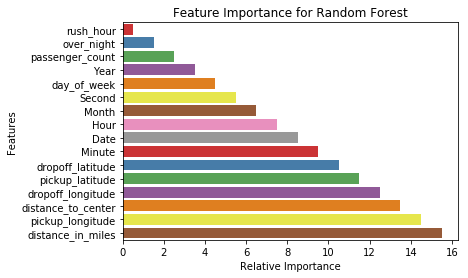

In [288]:
feature_importance = randomForestImproved.feature_importances_
sorted_idx = np.argsort(feature_importance)
pos = np.arange(sorted_idx.shape[0]) + .5
sns.barplot(pos,X_train.columns[sorted_idx], palette = 'Set1')
plt.xlabel('Relative Importance')
plt.ylabel('Features')
plt.title('Feature Importance for Random Forest')

In [290]:
from yellowbrick.regressor import ResidualsPlot

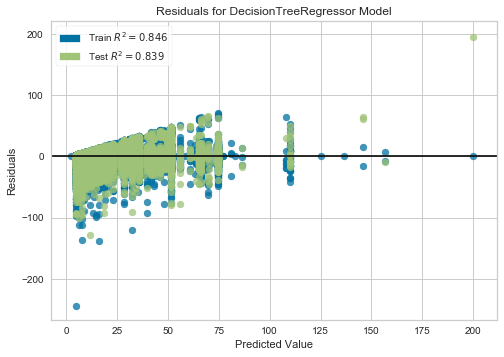

In [293]:
visualizerDT = ResidualsPlot(modelTreeReg3)

visualizerDT.fit(X_train, y_train)  # Fit the training data to the model
visualizerDT.score(X_val, y_val)  # Evaluate the model on the test data
visualizerDT.poof()                 # Draw/show/poof the data

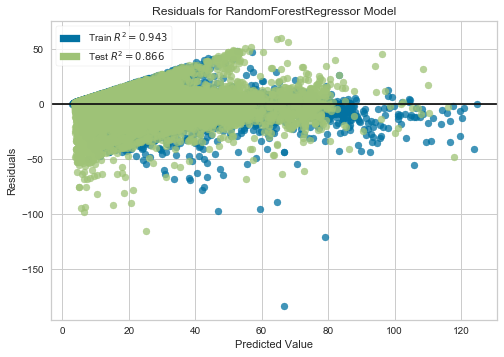

In [294]:
# Instantiate the visualizer
visualizer = ResidualsPlot(model)

visualizer.fit(X_train, y_train)  # Fit the training data to the model
visualizer.score(X_val, y_val)  # Evaluate the model on the test data
visualizer.poof()                 # Draw/show/poof the data

### FEATURE CORRELATION

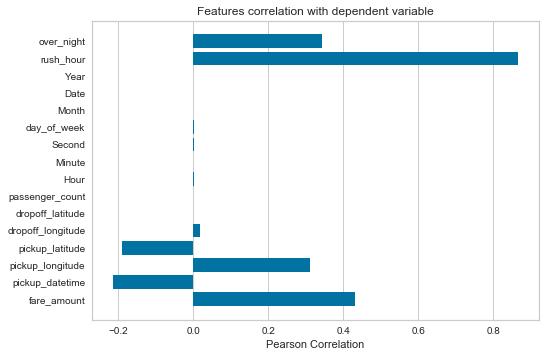

In [296]:
from yellowbrick.target import FeatureCorrelation

# Load the regression data set
# data = datasets.load_diabetes()
# X, y = data['data'], data['target']
feature_names = np.array(columns)

visualizer = FeatureCorrelation(labels=feature_names)
visualizer.fit(X, y)
visualizer.poof()

#### CROSS VALIDATION VISUALIZATION

In [301]:
# from sklearn.model_selection import KFold
# from yellowbrick.model_selection import CVScores

# # Create a new figure and axes
# _, ax = plt.subplots()

# cv = KFold(12)

# oz = CVScores(model, ax=ax, cv=cv)

# oz.fit(X, y)
# oz.poof()